In [1]:
import os
import madmom
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datasets import Dataset
from modules.energy_based import simple_energy_onsets
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer
from modules.analysis_funcs import get_segmented_data, get_test_peaks, merging_module, slur_alignment, aubio_peakpicker_do
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2

In [2]:
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds_test = Dataset("slurtest_test")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths() + ds_test.get_audio_paths()
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths() + ds_test.get_annotation_paths()
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
audio_lengths = [len(audio)/sr for audio, sr in zip(audios, sample_rates)]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [3]:
bock = madmom.features.onsets.CNNOnsetProcessor()
pp = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=0.7, combine=0.1)

In [5]:
# CNN method
base_path = "results/cnn-training-220426/"
model_name = "ab-seq-90eps-nostandard-trainable-noextend-dropout0.3"
model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))

# Validation models
#base_path = "results/cnn-training-220423/"
#model_name = "ab-seq-100eps-nostandard"
#model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))

In [6]:
sigg = madmom.audio.signal.SignalProcessor(num_channels=1)
frame = madmom.audio.signal.FramedSignalProcessor(frame_size=256, hop_size=441)
stft = madmom.audio.stft.STFTProcessor()
proc = madmom.processors.SequentialProcessor([sigg, frame, stft])

def get_hfc_onsets(fname, sr):
    hfc = madmom.features.onsets.high_frequency_content(np.abs(proc(fname)))
    onehot, out = aubio_peakpicker_do(hfc, threshold=0.5)
    peaks = (np.where(onehot==1)[0]-5)*441/sr
    return peaks

In [8]:
R = 39
with open("datasets/slurtest_add/sc_onsets/" + os.path.basename(audio_fnames[R])[:-4] + "_sc.csv") as file:
    sc_data = file.readlines()
sc_onsets = np.array([float(onset.strip()) for onset in sc_data])
note_onsets = np.unique(sc_onsets)
print(os.path.basename(audio_fnames[R])[:-4])

slurtest09_IR1


In [41]:
# OET, move after recording selection if used
mean_at_hard = np.load("results/computed/mean_energy_at_hard_onsets_AB.npy")
mean_at_soft = np.load("results/computed/mean_energy_at_soft_onsets_AB.npy")
energies = np.load("results/computed/AB_energies.npy")
general_threshold = np.mean(audio_lengths[:36]*(mean_at_soft-mean_at_hard)/energies)

sig = madmom.audio.signal.Signal(audio_fnames[R], dtype=float)
e_threshold = general_threshold*sig.energy()/audio_lengths[R]
frames = madmom.audio.signal.FramedSignal(signal=sig, frame_size=1024, fps=100)

oet_hard_idx = np.where(frames.energy()[(note_onsets*100).astype(int)]<e_threshold)[0]
oet_soft_idx = np.where(frames.energy()[(note_onsets*100).astype(int)]>e_threshold)[0]

/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [9]:

#bock_onsets = pp(bock("datasets/slurtest_add/slurtest_add_audio/6xtscale_220306resampled.wav"))

cnn_input = get_segmented_data(audio_fnames[R])
#cnn_input = get_segmented_data("datasets/slurtest_add/slurtest_add_audio/6xtscale_220306resampled.wav")
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, 1./100)

# Uncomment to get HFC
hfc_onsets = np.genfromtxt(fname="datasets/slurtest_add/hfc2_detections/" + os.path.basename(audio_fnames[R])[:-4] + ".csv")
#hfc_onsets = get_hfc_onsets(audio_fnames[R], sample_rates[R])
#hfc_onsets = get_hfc_onsets("datasets/slurtest_add/slurtest_add_audio/6xtscale_220306resampled.wav", 44100)


In [17]:
hard_idx, soft_idx = merging_module(note_onsets, hfc_onsets, tol_sec=0.05)
slur_pred = slur_alignment(hard_idx, soft_idx)
hard_gt, soft_gt = merging_module(note_onsets, onset_schedules[R], tol_sec=0.05)
slur_true = slur_alignment(hard_gt, soft_gt)
print(100-100*np.sum(0.5*np.sum(np.abs(slur_true-slur_pred), 1))/len(slur_true))

57.142857142857146


Text(0.5, 0, 'Time [s]')

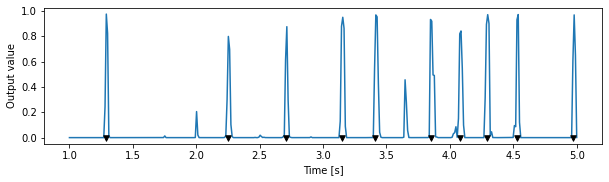

In [16]:
fig,ax = plt.subplots(figsize=(10,2.5))
passages = passage_extractor(
    cnn_output,
    [
        cnn_onsets,
    ],
    [1,5], 
    sr=100
)
onset_visualizer(
        passage=passages[0],
        ax=ax
)

ax.set_ylabel("Output value")
ax.set_xlabel("Time [s]")

Audio length:  32.8004081632653  s
Segments: [0.0, 8.0, 16.0, 24.0, 32.0, 40.0]


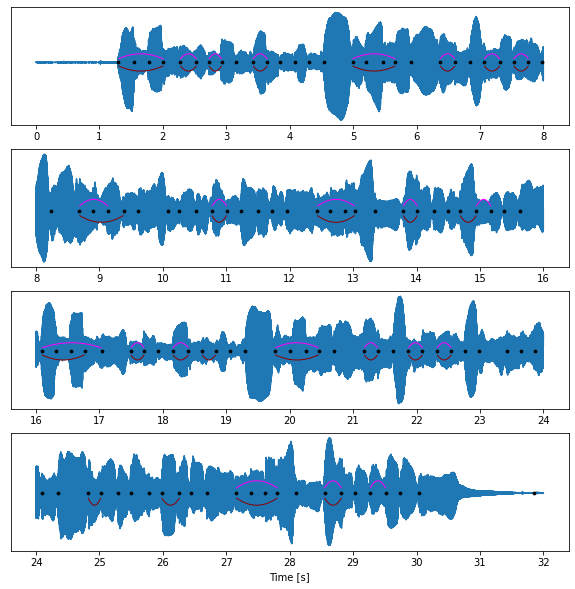

In [11]:

SPP = 8.0 # seconds per plot
print("Audio length: ", audio_lengths[R], " s")
print("Segments:", list(np.arange(0, audio_lengths[R]+SPP, SPP)))
N_PLOTS = int(audio_lengths[R]/SPP)+1
plot_slurs = True

passages = passage_extractor(
    audios[R], 
    [
        note_onsets,
        onset_schedules[R],
        cnn_onsets,
        #note_onsets[np.where(slur_pred[:,0]==1)[0]],
        #note_onsets[np.where(slur_pred[:,1]==1)[0]],
        #note_onsets[np.where(slur_pred[:,2]==1)[0]],
        #note_onsets[np.where(slur_pred[:,3]==1)[0]]

        
    ],
    np.arange(0, audio_lengths[R], SPP), 
    sr=sample_rates[R]
)

fig,axs = plt.subplots(len(passages),1, figsize=(10,2.5*len(passages)))
onset_styles = {"m":[
    ".", 
    "x",
    "^", 
    "<", "s", ">", "P"
    ], "c":[
    "k", 
    "r",
    "purple", 
    "magenta", "magenta", "magenta", "magenta"
]}
axs[-1].set_xlabel("Time [s]")

for plot_i, (passage, ax) in enumerate(zip(passages, axs)):
    ax.set_yticks([])
    onset_visualizer(
        audio=passage["audio"], 
        onset_list=[passage["onsets"][0]], 
        #passage["onsets"], 
        lims=(passage["abs_start"], passage["abs_end"]),
        onset_styles=onset_styles,
        ax=ax
        )
    if plot_slurs:
        qual_pred = merging_module(
            passage["onsets"][0], # Böck NOD
            passage["onsets"][2], # CNN HOD
            tol_sec=0.05
        )
        qual_true = merging_module(
            passage["onsets"][0], # Böck NOD
            passage["onsets"][1], # Annotated
            tol_sec=0.05
        )
        slur_pred = slur_alignment(qual_pred[0], qual_pred[1])
        slur_true = slur_alignment(qual_true[0], qual_true[1])
        slur_visualizer(
            passage["onsets"][0],
            slur_pred,
            ax=ax,
            edgecolor="magenta",
            sign=0.5
        )
        slur_visualizer(
            passage["onsets"][0],
            slur_true,
            ax=ax,
            edgecolor="darkred",
            sign=-0.5
        )


In [1]:
passages = [passage_extractor(
    frames.energy(), 
    onset_set,
    [1.0,4.5], 
    sr=sample_rates[R]
)[0] for onset_set in [
    [
        onset_schedules[R]
    ],
    [
        note_onsets,
    ],
]
]

fig,axs = plt.subplots(len(passages),1, figsize=(12,2.5*len(passages)), sharex=True)
onset_styles = [
    {"m":["x"], "c":["red"]},
    {"m":["o"], "c":["k"]}
]
if False:
    hard_idx, soft_idx = merging_module(
        passages[1]["onsets"][0], # Böck NOD
        passages[0]["onsets"][1], # CNN HOD
        tol_sec=0.05
    )

    hard_gt, soft_gt = merging_module(
        passages[1]["onsets"][0], # Böck NOD
        passages[0]["onsets"][0], # HOD annotations
        tol_sec=0.05
    )

for plot_i, (passage, ax, onset_style) in enumerate(zip(passages, axs, onset_styles)):
    ax.set_yticks([])
    onset_visualizer(
        passage=passage,
        onset_styles=onset_style,
        ax=ax,
        alpha=0.5
        )
    #if plot_i==1:
    if False:
        ax.set_xlabel("Time [s]")
        for hard, soft, sign, color in zip(
            [hard_idx, hard_gt],
            [soft_idx, soft_gt],
            [-0.5,0.5],
            ["purple", "red"]
        ):
            slur_visualizer(
                passages[1]["onsets"][0],
                slur_alignment(hard, soft),
                ax=ax,
                edgecolor=color,
                sign=sign
)

SyntaxError: invalid syntax (1233858517.py, line 38)

In [2]:
fig,ax = plt.subplots(1,1, figsize=(10,2.5))
passage = passage_extractor(
    frames.energy(), 
    [
        note_onsets,
        note_onsets[oet_hard_idx]
    ],
    [1.0,4.5], 
    sr=100
)[0]

onset_visualizer(
    passage=passage,
    onset_styles={"m":[".", "^"], "c":["k", "purple"]},
    ax=ax
)
ax.axhline(y=e_threshold)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Energy")


NameError: name 'plt' is not defined

[   27.5           56.93636583    87.56379644   119.43048514
   152.58657522   187.0842389    222.97775942   260.32361643
   299.1805749    339.60977755   381.6748411    425.44195633
   470.97999227   518.36060454   567.65834814   618.95079471
   672.31865464   727.84590406   785.61991695   845.73160267
   908.27554896   973.35017083  1041.05786538  1111.50517295
  1184.80294473  1261.06651723  1340.41589375  1422.97593318
  1508.87654654  1598.2529013   1691.24563418  1788.00107236
  1888.67146376  1993.41521663  2102.39714879  2215.78874696
  2333.76843663  2456.5218628   2584.24218211  2717.13036677
  2855.3955208   2999.25520907  3148.93579962  3304.67281989
  3466.71132731  3635.30629491  3810.72301254  3993.23750429
  4183.13696284  4380.72020136  4586.29812372  4800.19421369
  5022.74504393  5254.30080565  5495.22585962  5745.89930951
  6006.7155984   6278.08512948  6560.43491182  6854.20923228
  7159.87035462  7477.89924688  7808.7963382   8153.08230627
  8511.29889661  8884.00

Text(0, 0.5, 'Frequency [Hz]')

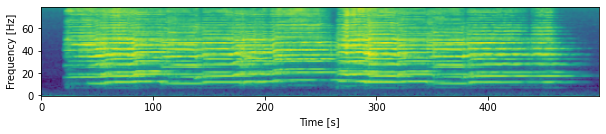

In [117]:
fig,ax = plt.subplots(1,1, figsize=(10,2.5))
passage = passage_extractor(
    cnn_input[:,:,7,0], 
    [
        onset_schedules[R],
        cnn_onsets
    ],
    [0.5,5.5], 
    sr=100
)[0]

ax.imshow(passage["audio"].transpose())
"""
onset_visualizer(
    passage=passage,
    onset_styles={"m":["x", "^"], "c":["r", "white"]},
    ax=ax
)
"""
melf = madmom.audio.filters.mel_frequencies(80, 27.5, 16000)
print(melf)
plt.imshow(passage["audio"].transpose(), origin="lower")
#ax.set_yticks([3,22,70])
#ax.set_yticklabels(["100", "1000", "10,000"])
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")


In [ ]:
# Saving 

f = open("datasets/slurtest_add/cnn_detections/" + os.path.basename(audio_fnames[R])[:-4] + ".csv", "w")
for i in range(len(cnn_onsets)):
    f.write("{:.3f}".format(cnn_onsets[i])+ "\n")
f.close()

f = open("datasets/slurtest_add/hfc_detections/" + os.path.basename(audio_fnames[R])[:-4] + ".csv", "w")
for i in range(len(hfc_onsets)):
    f.write("{:.3f}".format(hfc_onsets[i])+ "\n")
f.close()
f = open("datasets/slurtest_add/oet_detections/" + os.path.basename(audio_fnames[R])[:-4] + ".csv", "w")
for i in range(len(note_onsets[oet_hard_idx])):
    f.write("{:.3f}".format(note_onsets[oet_hard_idx][i])+ "\n")
f.close()